In [1]:
import os
import nest_asyncio
import pickle
nest_asyncio.apply()

import pyshark

import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autotime

time: 123 µs (started: 2021-07-31 16:14:25 +00:00)


In [3]:
## Loading data

time: 7.72 ms (started: 2021-07-31 16:14:25 +00:00)


In [4]:
def loadDataset(path, extraId=""):       
    cap = pyshark.FileCapture(path, use_json=True, include_raw=True)
    cap.load_packets()
    raw_data_list = [c.get_raw_packet() for c in cap]

    dataset = []
    
    for raw_data in raw_data_list:
        arr = np.zeros((75, 20), dtype=np.uint8)
        x, y = 0, 0
        for e in raw_data:
            arr[x, y] = e
            x += 1
            if x == 75:
                x = 0
                y += 1
            if y == 20:
                break
        dataset.append(arr.flatten())  
    return np.asarray(dataset)

time: 1.39 ms (started: 2021-07-31 16:14:25 +00:00)


In [5]:
badQueries = loadDataset('./dataset/badHttpQueriesFiltered.pcap', extraId=".flatten")

badCount = len(badQueries)

time: 1min 1s (started: 2021-07-31 16:14:25 +00:00)


In [6]:
badCount

153824

time: 2.7 ms (started: 2021-07-31 16:15:27 +00:00)


In [7]:
validQueries = loadDataset('./dataset/goodHttpQueriesFiltered.pcap', extraId=".flatten")

validCount = len(validQueries)

time: 1min 5s (started: 2021-07-31 16:15:27 +00:00)


In [8]:
validCount

148962

time: 1.79 ms (started: 2021-07-31 16:16:32 +00:00)


In [9]:
## Preparing the dataset

time: 7.52 ms (started: 2021-07-31 16:16:32 +00:00)


In [10]:
yBad = [1 for i in range(0, len(badQueries))]  #labels, 1 for malicious and 0 for clean
yGood = [0 for i in range(0, len(validQueries))]

time: 9.39 ms (started: 2021-07-31 16:16:32 +00:00)


In [11]:
X = np.concatenate((badQueries, validQueries), axis=0)
y = yBad + yGood

time: 54.6 ms (started: 2021-07-31 16:16:32 +00:00)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #splitting data

time: 129 ms (started: 2021-07-31 16:16:32 +00:00)


In [13]:
## Building the model

time: 195 µs (started: 2021-07-31 16:16:33 +00:00)


In [14]:
def gen_model(input_size, hidden_layer_count, hidden_layer_size, activation_fn='sigmoid'):
    model = Sequential()

    model.add(Dense(input_size))
    for _ in range(hidden_layer_count):
        model.add(Dense(hidden_layer_size, activation=activation_fn))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

time: 1.09 ms (started: 2021-07-31 16:16:33 +00:00)


In [15]:
model = gen_model(75 * 20, 6, 128, activation_fn='sigmoid')

time: 38.9 ms (started: 2021-07-31 16:16:33 +00:00)


In [16]:
## Training

time: 192 µs (started: 2021-07-31 16:16:33 +00:00)


In [17]:
def train_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=3)

    return model, test_loss, test_acc, history

time: 1.63 ms (started: 2021-07-31 16:16:33 +00:00)


In [18]:
model, test_loss, test_acc, history = train_model(model, 5, 32, X_train, y_train, X_test, y_test)

Epoch 1/5
7570/7570 [==============================] - 46s 6ms/step - loss: 0.2536 - accuracy: 0.5002 - val_loss: 0.2506 - val_accuracy: 0.4884
Epoch 2/5
7570/7570 [==============================] - 45s 6ms/step - loss: 0.2527 - accuracy: 0.4983 - val_loss: 0.2551 - val_accuracy: 0.4884
Epoch 3/5
7570/7570 [==============================] - 45s 6ms/step - loss: 0.2520 - accuracy: 0.5019 - val_loss: 0.2502 - val_accuracy: 0.5116
Epoch 4/5
7570/7570 [==============================] - 45s 6ms/step - loss: 0.2519 - accuracy: 0.5020 - val_loss: 0.2553 - val_accuracy: 0.5116
Epoch 5/5
7570/7570 [==============================] - 46s 6ms/step - loss: 0.2517 - accuracy: 0.5019 - val_loss: 0.2499 - val_accuracy: 0.5116
time: 3min 50s (started: 2021-07-31 16:16:33 +00:00)


In [19]:
## Metrics

time: 301 µs (started: 2021-07-31 16:20:24 +00:00)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1500)              2251500   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               192128    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [21]:
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

Loss:  0.24993754923343658
Accuracy:  0.5116087198257446
time: 990 µs (started: 2021-07-31 16:20:24 +00:00)


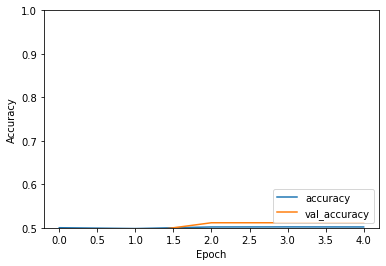

time: 140 ms (started: 2021-07-31 16:20:24 +00:00)


In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [23]:
## Testing

time: 214 µs (started: 2021-07-31 16:20:24 +00:00)


In [24]:
def frame_is_bad(frame):
    return round(max(0., min(1., model.predict(np.asarray([frame]))[0][0])) * 100, 2)

time: 4.25 ms (started: 2021-07-31 16:20:24 +00:00)


In [25]:
print("Is bad ?", frame_is_bad(X_test[0]), "%")

Is bad ? 52.01 %
time: 83.2 ms (started: 2021-07-31 16:20:24 +00:00)
